In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import torch
from torch.cuda.amp import autocast
from nltk import ngrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
import torch


# Load the dataset
data = pd.read_csv('hateXplain.csv')

# Display the first few rows of the dataset to understand its structure
data.head()


## EDA

In [2]:
# Check the basic structure of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60444 entries, 0 to 60443
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_id       60444 non-null  object
 1   annotator_id  60444 non-null  int64 
 2   label         60444 non-null  object
 3   target        39252 non-null  object
 4   post_tokens   60444 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [4]:
# Summary statistics of the dataset (only for numeric columns)
data.describe()


count      60444
unique         3
top       normal
freq       24449
Name: label, dtype: object

In [5]:
# Checking for missing values in each column
data.isnull().sum()

post_id             0
annotator_id        0
label               0
target          21192
post_tokens         0
dtype: int64

In [6]:
# Display the column names in the dataset
data.columns


Index(['post_id', 'annotator_id', 'label', 'target', 'post_tokens'], dtype='object')

majority_label
normal        7814
hatespeech    6854
offensive     5480
Name: count, dtype: int64


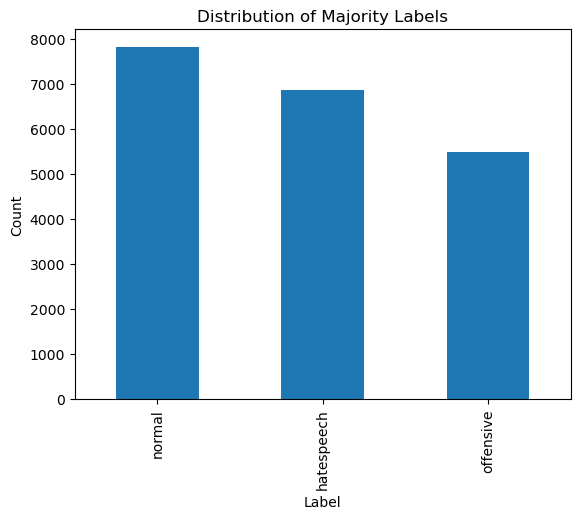

In [7]:
# Group by 'post_id' and determine the majority label
majority_labels = data.groupby('post_id')['label'].agg(lambda x: x.mode()[0])

# Add this majority label to the original DataFrame
data = data.drop_duplicates(subset='post_id').set_index('post_id')
data['majority_label'] = majority_labels

# Analyze the distribution of the majority labels
print(data['majority_label'].value_counts())

# Visualize the label distribution
data['majority_label'].value_counts().plot(kind='bar')
plt.title('Distribution of Majority Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
# Calculate the length of each post by counting the tokens
data['post_length'] = data['post_tokens'].str.split().str.len()


# Display basic statistics about post length
print("Basic statistics about post length (in tokens):")
print(data['post_length'].describe())


# Create a histogram to show the distribution of post lengths
fig = px.histogram(
    data, 
    x='post_length', 
    nbins=20, 
    title='Distribution of Post Lengths (in Tokens)', 
    labels={'post_length': 'Number of Tokens'}, 
    template='plotly_dark',
    marginal="box",  # Adding a box plot on top for additional insights
    opacity=0.75,    # Adjusting opacity for better visualization
    color_discrete_sequence=['#FFA07A'],  # Custom color for the bars
)

# Update the layout for better readability
fig.update_layout(
    title_font=dict(size=24, family='Arial, sans-serif', color='#FFFFFF'),
    xaxis_title='Number of Tokens',
    yaxis_title='Frequency',
    xaxis=dict(
        title_font=dict(size=18, family='Arial, sans-serif', color='#FFFFFF'),
        tickfont=dict(size=14, family='Arial, sans-serif', color='#FFFFFF'),
        showgrid=False,  # Removes grid lines for a cleaner look
    ),
    yaxis=dict(
        title_font=dict(size=18, family='Arial, sans-serif', color='#FFFFFF'),
        tickfont=dict(size=14, family='Arial, sans-serif', color='#FFFFFF'),
        showgrid=False,  # Removes grid lines for a cleaner look
    ),
    plot_bgcolor='#2C2C2C',  # Set background color for the plot area
    paper_bgcolor='#1F1F1F',  # Set background color for the entire figure
)

# Display the plot
fig.show()


Basic statistics about post length (in tokens):
count    20148.000000
mean        23.570528
std         13.824505
min          2.000000
25%         12.000000
50%         21.000000
75%         34.000000
max        165.000000
Name: post_length, dtype: float64


In [9]:
def plot_top_n_targets(data, n=10, display_inline=True, save_image=False, image_name='plot.png'):
    # Analyze the distribution of targets and get the top N
    target_counts = data['target'].value_counts().nlargest(n)

    # Create a DataFrame for plotting
    target_counts_df = target_counts.reset_index()
    target_counts_df.columns = ['Target Group', 'Count']

    # Create an interactive horizontal bar chart using Plotly
    fig = px.bar(target_counts_df, 
                 x='Count', 
                 y='Target Group', 
                 orientation='h', 
                 title=f'Top {n} Target Groups',
                 labels={'Count': 'Count', 'Target Group': 'Target Group'},
                 color='Count',
                 color_continuous_scale='Viridis')

    # Update the layout for better readability
    fig.update_layout(
        xaxis_title="Count",
        yaxis_title="Target Group",
        title_font_size=20,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=False),
        plot_bgcolor='rgba(0,0,0,0)'
    )

    if display_inline:
        # Use Plotly's offline mode to display the plot inline (for Jupyter)
        pyo.iplot(fig)
    elif save_image:
        # Save the plot as a static image
        fig.write_image(image_name)
    else:
        # Show the plot in a browser window
        fig.show()

# Example usage: Plot the top 10 target groups and display inline
plot_top_n_targets(data, n=20)

def plot_distributions(df):
    columns_to_plot = df.columns[1:]
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(2, 3, i)  # Adjust the grid as needed (2 rows, 3 columns in this case)
        df[column].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_distributions(data)

In [10]:
# Create a crosstab to show the relationship between labels and targets
label_target_crosstab = pd.crosstab(data['majority_label'], data['target'])

# Convert the crosstab to a long-form dataframe for Plotly
crosstab_long = label_target_crosstab.reset_index().melt(id_vars='majority_label')

# Create a stacked bar plot
fig = px.bar(crosstab_long, x='majority_label', y='value', color='target',
             labels={'value':'Count', 'majority_label':'Label'}, 
             title='Correlation Between Labels and Targets', template='plotly_dark')

# Show the plot
fig.show()


In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar Spacy para NER
nlp = spacy.load("en_core_web_sm")

# Ampliar el conjunto de stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'like', 'would', 'could', 'said', 'also', 'even', 'just', 'really', 'think', 
    'know', 'want', 'go', 'going', 'get', 'got', 'say', 'make', 'see', 'one', 
    'let', 'take', 'back', 'come', 'still', 'time', 'good', 'look', 'well', 
    'right', 'way', 'new', 'people', 'thing', 'now', 'need', 'much', 'many', 
    'every', 'always', 'feel', 'give', 'use', 'look', 'year', 'day'
}

stop_words.update(custom_stopwords)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Preprocesamiento del texto: Lematización, Stemming, NER y eliminación de caracteres especiales y stopwords
def preprocess_text(text):
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenizar el texto
    tokens = word_tokenize(text.lower())
    
    # Aplicar NER para identificar nombres propios que no deben ser eliminados
    doc = nlp(text)
    entities = {ent.text.lower() for ent in doc.ents}
    
    # Eliminar stopwords, aplicar lematización y stemming
    processed_tokens = []
    for token in tokens:
        if token not in stop_words and token not in entities:
            # Aplicar lematización y stemming
            token = lemmatizer.lemmatize(token)
            token = stemmer.stem(token)
            processed_tokens.append(token)
    
    return ' '.join(processed_tokens)

# Cargar los datos
hate = pd.read_csv('hateXplain.csv')
final_hate = pd.read_csv('final_hateXplain.csv')

# Aplicar preprocesamiento al texto
hate['post_tokens'] = hate['post_tokens'].apply(preprocess_text)
final_hate['comment'] = final_hate['comment'].apply(preprocess_text)  # Aplicar a la columna 'comment'

# Eliminar filas con valores nulos en las columnas clave en el DataFrame hate
hate = hate.dropna(subset=['post_id', 'label', 'post_tokens'])

# Eliminar filas con valores nulos en las columnas clave en el DataFrame final_hate
final_hate = final_hate.dropna(subset=['comment', 'label'])

# Agrupar por 'post_id' y seleccionar la etiqueta más frecuente para cada publicación
grouped_df = hate.groupby('post_id')
unique_label = grouped_df['label'].agg(lambda x: x.value_counts().index[0]).to_frame().reset_index()

# Crear el conjunto de entrenamiento
X_train = pd.merge(left=hate[['post_id', 'post_tokens']], right=unique_label, on='post_id', how='inner').drop_duplicates(subset=['post_id']).reset_index(drop=True)

# Definir el vectorizador TF-IDF
tfidf = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 6), max_features=500000, min_df=5)

# Definir el codificador de etiquetas
oe = OrdinalEncoder(categories=[['normal', 'offensive', 'hatespeech']])

# Ajustar el TF-IDF y el codificador de etiquetas
tfidf.fit(X_train['post_tokens'])
oe.fit(X_train[['label']])

# Funciones para extraer características y etiquetas
def get_features(tfidf, x, text_column):
    tfidf_feature = tfidf.transform(x[text_column])
    return tfidf_feature

def get_labels(oe, x):
    y = oe.transform(x[['label']])
    return y

# Obtener características y etiquetas para el entrenamiento y la prueba
x_train = get_features(tfidf, X_train, 'post_tokens')
y_train = get_labels(oe, X_train)
x_test = get_features(tfidf, final_hate, 'comment')  # Aplicar a la columna 'comment'
y_test = get_labels(oe, final_hate)

# Aplicar reducción de dimensionalidad con TruncatedSVD
svd = TruncatedSVD(n_components=300)  # Reduce las dimensiones a 300
x_train_reduced = svd.fit_transform(x_train)
x_test_reduced = svd.transform(x_test)

# Utilizar SMOTE para manejar el desbalanceo de clases en los datos de entrenamiento
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_reduced, y_train)

# Ajustar el modelo MLP con más iteraciones y con tolerancia definida
mlp = MLPClassifier(
    random_state=0,
    verbose=True,
    batch_size=2000,
    max_iter=3000,  # Aumentar el número máximo de iteraciones
    tol=0,  # Establecer la tolerancia a 0 para que no se detenga por mejoras mínimas en la pérdida
    early_stopping=False,  # Deshabilitar el early stopping basado en la tolerancia
    warm_start=True
)


# Validación cruzada con 5 particiones
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, x_train_resampled, y_train_resampled.ravel(), cv=cv, scoring='f1_macro')

# Imprimir el puntaje promedio y la desviación estándar
print(f"F1 Macro Average (Cross-validation): {cv_scores.mean():.4f}")
print(f"F1 Macro Std Dev (Cross-validation): {cv_scores.std():.4f}")

# Entrenar el modelo con el conjunto de entrenamiento completo
mlp.fit(x_train_resampled, y_train_resampled.ravel())

# Hacer predicciones y generar el reporte de clasificación
y_pred = mlp.predict(x_test_reduced)
print(classification_report(y_test, y_pred))

# Generar matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['normal', 'offensive', 'hatespeech'], yticklabels=['normal', 'offensive', 'hatespeech'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Bloque separado para graficar la curva de pérdida a lo largo de las iteraciones
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Hacer predicciones y generar el reporte de clasificación
y_pred = mlp.predict(x_test_reduced)
print(classification_report(y_test, y_pred))
